In [1]:
import os
import torchattacks
import numpy as np
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith('__') and
                     callable(models.__dict__[name]))

In [5]:
model = models.__dict__['resnet50'](pretrained=True)

/home/abdulrauf/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdulrauf/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def image_folder_custom_label(root, transform, idx2label) :
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root=root, transform=transform, 
                                 target_transform=lambda x : idx2label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [10]:
def load_labels_from_txt(file_path):
    """Loads class labels from a .txt file, where each line contains a label."""
    with open(file_path, "r") as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

def get_imagenet_data():
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # Load ImageNet class labels from a .txt file instead of JSON
    idx2label = load_labels_from_txt("/home/abdulrauf/Desktop/ImageNet-100-Pytorch/IN100.txt")

    # Define transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        # transforms.Normalize(mean=MEAN, std=STD)
    ])

    # Load dataset with custom labels
    imagnet_data = image_folder_custom_label(root='/media/abdulrauf/c6e51537-17d9-4e8c-bfac-00f1c3719a0b/IN100/train', 
                                             transform=transform,
                                             idx2label=idx2label)

    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=512, shuffle=False)

    print("Used normalization: mean=", MEAN, "std=", STD)
    
    # Return the first batch
    # return next(iter(data_loader))
    return data_loader

In [11]:
data = get_imagenet_data()
imgs, labels = next(iter(data))

Used normalization: mean= [0.485, 0.456, 0.406] std= [0.229, 0.224, 0.225]


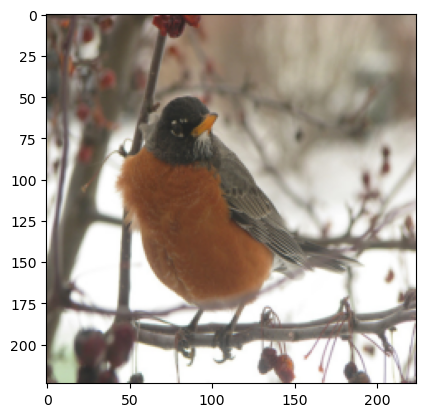

In [15]:
plt.imshow(imgs[0].permute(1,2,0))

In [8]:
atk = torchattacks.PGD(model.to(device), eps=8/255, alpha=2/255, steps=10, random_start=True)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(atk)

PGD(model_name=ResNet, device=cuda:0, attack_mode=default, targeted=False, normalization_used=True, eps=0.03137254901960784, alpha=0.00784313725490196, steps=10, random_start=True)


In [9]:
def adv_generator(train_loader):
    adv_batches = []
    label_batches = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        adv_batch = atk(images, labels) 
        adv_batches.append(adv_batch.cpu().detach())
        label_batches.append(labels.cpu().detach())
    # Concatenate images and labels
    adv_images = torch.cat(adv_batches, dim=0)
    adv_labels = torch.cat(label_batches, dim=0)
    
    # Convert adversarial images to numpy, clip values to [0, 1], and save in uint8
    adv_images = adv_images.permute(0, 2, 3, 1).numpy()  # Convert to HWC format
    adv_images = np.clip(adv_images, 0, 1)  # Clip to valid range
    adv_images = (adv_images * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
    return adv_images, adv_labels

In [10]:
train_loader = get_imagenet_data()

Used normalization: mean= [0.485, 0.456, 0.406] std= [0.229, 0.224, 0.225]


In [11]:
adversarial_dataset = adv_generator(train_loader)

In [12]:
adv_imgs = adversarial_dataset[0]
adv_labels = adversarial_dataset[1]

In [13]:
adv_labels[120000]

tensor(51)

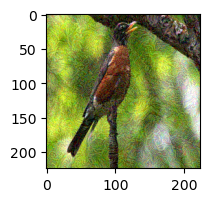

In [14]:
plt.figure(figsize=(2,2))
plt.imshow(adv_imgs[20])

In [15]:
np.save('/home/abdulrauf/Desktop/augmix/adversarial_dataset1.npy', adversarial_dataset[0])
np.save('/home/abdulrauf/Desktop/augmix/adversarial_label1.npy', adversarial_dataset[1])

In [ ]:
path = '/media/abdulrauf/c6e51537-17d9-4e8c-bfac-00f1c3719a0b/IN100'
train_transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip()
      ])
traindir =  os.path.join(path, 'train')
dataset = datasets.ImageFolder(traindir, train_transform)

In [ ]:
img, label = dataset[2]

In [ ]:
img

In [ ]:
plt.imshow(img.permute(1,2,0))

In [ ]:
train_loader = torch.utils.data.DataLoader(
      dataset,
      batch_size=16,
      shuffle=False,
      num_workers=4)

In [ ]:
first_batch =  next(iter(train_loader))

In [ ]:
first_batch[0][0]

In [ ]:
converted_img = ((first_batch[0][1]).permute(1,2,0).numpy()*255).astype(np.uint8)

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(converted_img)

In [ ]:
def adv_generator(train_loader):
    adv_batches = []
    label_batches = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        adv_batch = atk(images, labels) 
        adv_batches.append(adv_batch.cpu().detach())
        label_batches.append(labels.cpu().detach())
    # Concatenate images and labels
    adv_images = torch.cat(adv_batches, dim=0)
    adv_images = (adv_images.permute(0,2,3,1).numpy()*255).astype(np.uint8)
    adv_labels = torch.cat(label_batches, dim=0)
    return adv_images, adv_labels

In [ ]:
adversarial_dataset = adv_generator(train_loader)

In [ ]:
x = adversarial_dataset[0]


In [ ]:
class adversarial_generator(torch.utils.data.Dataset):
    def __init__(self, dataset, label):
        self.dataset = dataset
        self.label = label

    def __getitem__(self, i):
        x = self.dataset[i]
        y = self.label[i]
        x = Image.fromarray(x)
        return x,y
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
adv_dataset = adversarial_generator(adversarial_dataset)

In [ ]:
img,y =  adv_dataset[4]

In [ ]:
img

In [ ]:
np.save('/home/abdulrauf/Desktop/augmix/adversarial_dataset.npy', adversarial_dataset[0])
np.save('/home/abdulrauf/Desktop/augmix/adversarial_label.npy', adversarial_dataset[1])

In [ ]:
loaded_dataset = np.load('adversarial_dataset.npy')
labels = np.load('adversarial_label.npy')

In [ ]:
adv_dataset = adversarial_generator(loaded_dataset, labels)

In [ ]:
img, label = adv_dataset[0]

In [ ]:
img

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset and apply transformations
dataset = datasets.ImageFolder(traindir, test_transform)

In [ ]:
dataset = datasets.ImageFolder(traindir, test_transform)

In [ ]:
dataset.data = loaded_dataset
dataset.targets = labels

In [ ]:
val_loader = torch.utils.data.DataLoader(
      dataset,
      batch_size=1000,
      shuffle=False,
      num_workers=4)

In [ ]:
model=model.to(device)

In [ ]:
def test(net, test_loader):
  """Evaluate network on given dataset."""
  net.eval()
  total_loss = 0.
  total_correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images, targets = images.cuda(), targets.cuda()
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
      pred = logits.data.max(1)[1]
      total_loss += float(loss.data)
      total_correct += pred.eq(targets.data).sum().item()

  return total_loss / len(test_loader.dataset), total_correct / len(
      test_loader.dataset)

In [ ]:
loss, acc1 =  test(model, val_loader)

In [ ]:
100-100*acc1

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(loaded_dataset[3])

In [ ]:
loaded_dataset[3]

In [ ]:
len(labels)

In [ ]:
# adversarial_dataset = torch.cat(adversarial_dataset,dim=0)

In [ ]:
# adversarial_dataset = (adversarial_dataset.permute(0,2,3,1).numpy()*255).astype(np.uint8)

In [ ]:
imgs,labels = adversarial_dataset

In [ ]:
len(imgs)

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(imgs[0])

In [ ]:
images, labels = first_batch

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.imshow(images[0].permute(1,2,0))
plt.show()

In [ ]:
adv_images = atk(images, labels)

In [ ]:
adv_img =  adv_images[0]
plt.figure(figsize=(2,2))
plt.imshow(adv_img.permute(1,2,0))
plt.show()

In [ ]:
class AugMixDataset(torch.utils.data.Dataset):
  """Dataset wrapper to perform AugMix augmentation."""

  def __init__(self, dataset, preprocess):
    self.dataset = dataset
    self.preprocess = preprocess
    

  def __getitem__(self, i):
    x, y = self.dataset[i]
    x = self.preprocess(x)
    adv_data = adv_batch = atk(x, y)
    y = torch.tensor(y)
    return adv_data

  def __len__(self):
    return len(self.dataset)

In [ ]:
adv_dataset = AugMixDataset(dataset, transforms.ToTensor())

In [ ]:
adv_dataset[0]

In [ ]:
img, label = dataset[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [ ]:
def image_folder_custom_label(root, transform, idx2label) :
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root=root, transform=transform, 
                                 target_transform=lambda x : idx2label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data


In [ ]:
def load_labels_from_txt(file_path):
    """Loads class labels from a .txt file, where each line contains a label."""
    with open(file_path, "r") as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

def get_imagenet_data():
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # Load ImageNet class labels from a .txt file instead of JSON
    idx2label = load_labels_from_txt("/home/abdulrauf/Desktop/ImageNet-100-Pytorch/IN100.txt")

    # Define transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 244)),
        transforms.ToTensor()
        # transforms.Normalize(mean=MEAN, std=STD)
    ])

    # Load dataset with custom labels
    imagnet_data = image_folder_custom_label(root='/media/abdulrauf/c6e51537-17d9-4e8c-bfac-00f1c3719a0b/IN100/train', 
                                             transform=transform,
                                             idx2label=idx2label)

    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=256, shuffle=False)

    print("Used normalization: mean=", MEAN, "std=", STD)
    
    # Return the first batch
    return next(iter(data_loader))
    # return data_loader

In [ ]:
images, labels = get_imagenet_data()

In [ ]:
# images, labels = next(iter(train_loader))

In [ ]:
images[0]

In [ ]:
adv_images =  atk(images, labels)

In [ ]:
img = adv_images[0]
img = img.cpu().detach()
img = img.numpy()

In [ ]:
# img =  np.clip(img.numpy(),0,1)

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(img.transpose(1,2,0))

In [ ]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (2, 2))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [ ]:
imshow(adv_images[0], title='vis of image')